# **Object Detection - Models Testing - RF-DETR**

---

In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from rfdetr import RFDETRBase
%matplotlib inline

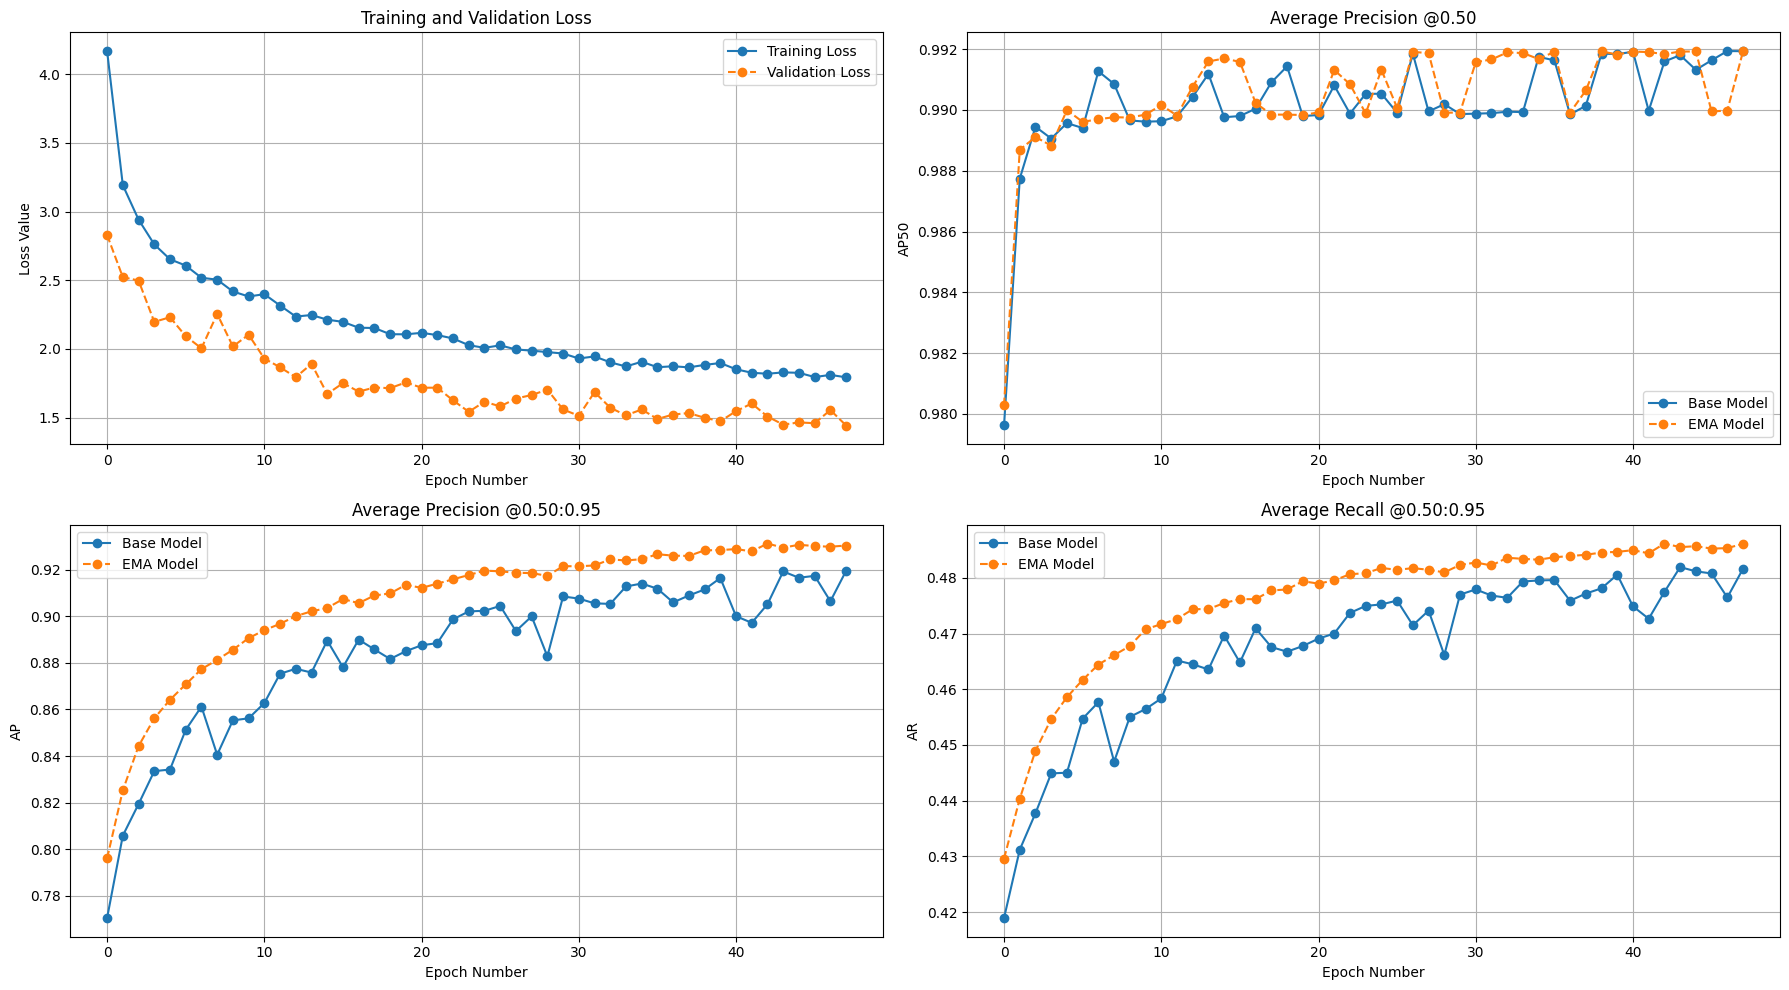

In [2]:
epochs, train_loss, val_loss = [], [], []
ap50_base, ap50_ema = [], []
ap_base, ap_ema = [], []
ar_base, ar_ema = [], []

with open("./output/log.txt") as f:
    for line in f:
        data = json.loads(line)
        if "epoch" not in data:
            continue

        epochs.append(data["epoch"])
        train_loss.append(data.get("train_loss", None))
        val_loss.append(data.get("test_loss", None))

        # COCO Eval Bbox metrics
        coco_base = data.get("test_coco_eval_bbox", [None] * 13)
        coco_ema = data.get("ema_test_coco_eval_bbox", [None] * 13)

        ap_base.append(coco_base[0])
        ap50_base.append(coco_base[1])
        ar_base.append(coco_base[6])

        ap_ema.append(coco_ema[0])
        ap50_ema.append(coco_ema[1])
        ar_ema.append(coco_ema[6])

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Loss plot
axs[0, 0].plot(epochs, train_loss, label="Training Loss", marker="o")
axs[0, 0].plot(epochs, val_loss, label="Validation Loss", marker="o", linestyle="--")
axs[0, 0].set_title("Training and Validation Loss")
axs[0, 0].set_xlabel("Epoch Number")
axs[0, 0].set_ylabel("Loss Value")
axs[0, 0].legend()
axs[0, 0].grid(True)

# AP @ 0.5
axs[0, 1].plot(epochs, ap50_base, label="Base Model", marker="o")
axs[0, 1].plot(epochs, ap50_ema, label="EMA Model", marker="o", linestyle="--")
axs[0, 1].set_title("Average Precision @0.50")
axs[0, 1].set_xlabel("Epoch Number")
axs[0, 1].set_ylabel("AP50")
axs[0, 1].legend()
axs[0, 1].grid(True)

# AP @ 0.50:0.95
axs[1, 0].plot(epochs, ap_base, label="Base Model", marker="o")
axs[1, 0].plot(epochs, ap_ema, label="EMA Model", marker="o", linestyle="--")
axs[1, 0].set_title("Average Precision @0.50:0.95")
axs[1, 0].set_xlabel("Epoch Number")
axs[1, 0].set_ylabel("AP")
axs[1, 0].legend()
axs[1, 0].grid(True)

# AR @ 0.50:0.95
axs[1, 1].plot(epochs, ar_base, label="Base Model", marker="o")
axs[1, 1].plot(epochs, ar_ema, label="EMA Model", marker="o", linestyle="--")
axs[1, 1].set_title("Average Recall @0.50:0.95")
axs[1, 1].set_xlabel("Epoch Number")
axs[1, 1].set_ylabel("AR")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

fig.savefig("./output/completed_metrics_plot.png")

In [3]:
rfdetr = RFDETRBase(pretrain_weights="./output/checkpoint_best_total.pth")

num_classes mismatch: pretrain weights has 5 classes, but your model has 90 classes
reinitializing detection head with 5 classes


Loading pretrain weights


In [4]:
test_image_path = "../../data/split_data/images/test/frame_0_aug_0.jpg"
frame = cv2.imread(test_image_path)
test_image = Image.fromarray(frame)
test_result = rfdetr.predict(test_image, threshold=0.5)
test_result

Detections(xyxy=array([[360.9351 , 354.4138 , 391.31006, 377.6624 ],
       [690.2418 , 316.92688, 717.5617 , 337.33398],
       [602.8183 , 511.36554, 629.1463 , 534.24976],
       [421.90533, 218.80698, 446.02753, 243.75671]], dtype=float32), mask=None, confidence=array([0.96868426, 0.9645768 , 0.9626913 , 0.9424138 ], dtype=float32), class_id=array([5, 2, 2, 5]), tracker_id=None, data={}, metadata={})

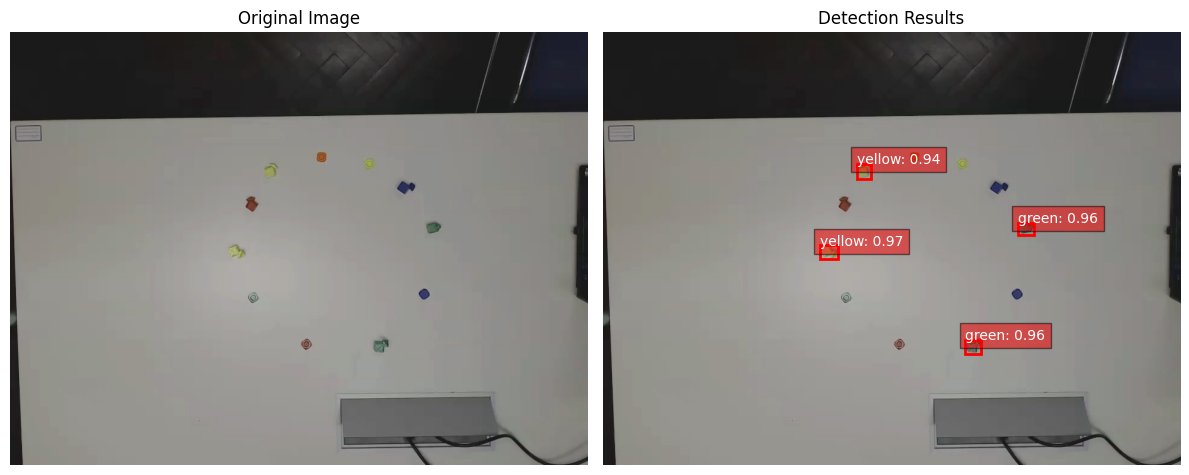

In [5]:
img = mpimg.imread(test_image_path)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show original image
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Show image with detection results
axs[1].imshow(img)
for box, cls, conf in zip(
    test_result.xyxy,
    test_result.class_id,
    test_result.confidence,
):
    x1, y1, x2, y2 = box
    axs[1].add_patch(
        plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
        )
    )
    label = f"{['none', 'blue', 'green', 'red', 'red', 'yellow'][int(cls)]}: {conf:.2f}"
    axs[1].text(
        x1, y1, label, color="white", fontsize=10, bbox=dict(facecolor="red", alpha=0.5)
    )
axs[1].set_title("Detection Results")
axs[1].axis("off")

plt.tight_layout()
plt.show()